In [1]:
import math
import numpy as np
import random

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        # want to be able to use integers with Value objects
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') # children of new value are the two operands, i.e. self and other
        
        # set out._backward to the function that propagates the graident

        def _backward():
            # local derivative in addition is 1
            # when adding two values, grad of operands = grad of output

            # we actually need to sum the gradients in the case of multivariate chain rule
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    # subtraction is a case of addition, where we add a negative value
    # we can implement negation and use addition

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # local derivative in addition is the other operand's value
            # when adding two values, grad of operands = value of other operand * grad of output
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out

    def __rmul__(self, other):
        # __rmul__ is used in the case of 2 * a
        # python doesn't know how to do this since it calls the __mul__ of the first operand
        # this is a fallback; python will then attempt the __rmul__ of the second operand
        return self * other

    # division is a simpler case of multiplying a * b^k, where k = -1
    # so we will implement the power function,
    # and use it for division

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')

        def _backward():
            # derivative of a^b wrt a is b*a^(b-1)
            self.grad += (other * self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**(-1)
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        # (self, ) creates a tuple with one object
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # local derivative for tanh is 1 - tanh(x)**2 = 1 - output^2
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            # derivative of e^x is e^x
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):

        # manually calling _backward() sucks, we want to do it automatically
        # what we're doing is starting from the right (the output) and calling _backward on the children
        # we can run a topological sort
        
        topo = []
        visited = set()

        def topo_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topo_sort(child)
                topo.append(v)
                
        topo_sort(self)

        # the node we call this function from will be considered the output
        # so its gradient is 1
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
# this code is used to visualize the neural network

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular {'record'} node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [75]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# output
o = n.tanh(); o.label = 'o'

o.backward()

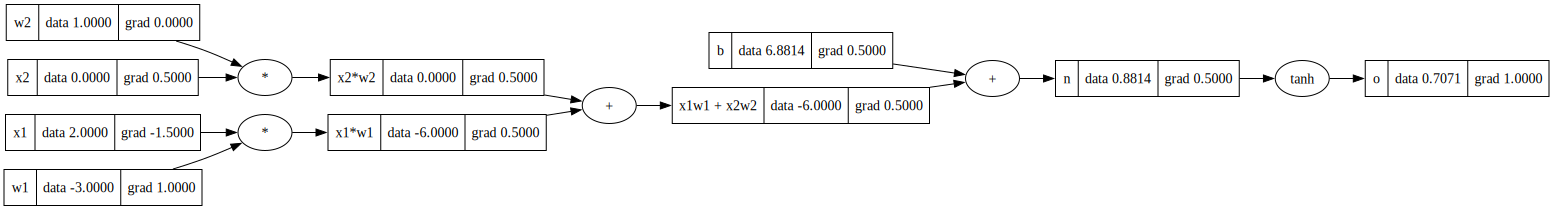

In [76]:
draw_dot(o)

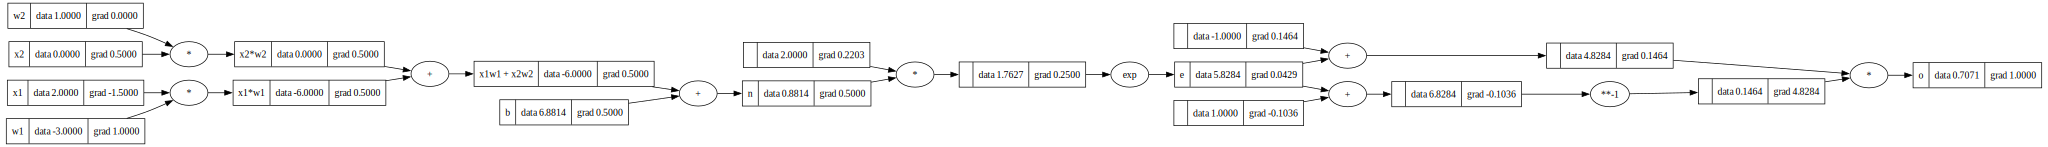

In [85]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# output
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()

draw_dot(o)

In [4]:
import torch

In [105]:
# same implementation in pytorch

# by default, pytorch will use float32
# we may want more precision and use float64 by casting as double using
# x.double()

# usually gradients are not desired for leaf nodes due to efficiency
# if gradients are required, then we must do
# x.requires_grad = True
x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# x.item() returns the scalar value of a 1-element tensor
print(o.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [15]:
class Neuron:
    def __init__(self, nin):
        # nin = number of inputs to this neuron
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # random weights
        self.b = Value(random.uniform(-1,1))                       # random bias

    def __call__(self, x):
        # this is op overload for n(x) where n is a Neuron object
        # we want this to sum the products x1w1, x2w2, etc. and then add b
        # we are taking the dot product x * w + b

        # zip(a, b) takes two iterators and creates an object of element-wise tuples
        # e.g. zip([1, 2, 3], [4, 5, 6]) returns an object with (1, 4), (2, 5), (3, 6)

        # act = activation
        # sum takes a second optional parameter, the base of the sum
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    # returns all parameters of this neuron (all weights and the bias)
    def parameters(self):
        return self.w + [self.b]

# we want to define a layer of Neurons
class Layer:

    def __init__(self, nin, nout):
        # nin is the number of inputs to the layer, which is the number of inputs to each neuron
        # nout is the number of outputs of the layer, which is the number of neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # evaluate each neuron and return as a list
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        # returns all parameters of all neurons
        return [p for neuron in self.neurons for p in neuron.parameters()]

# we want to define an MLP (multilayer perceptron)
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts                                               # number of neurons in each layer
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] # iterate over each pair of sizes in sz

    def __call__(self, x):
        for layer in self.layers:
            # loop and set x to the values of the next layer
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [23]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6357737454472442)

In [24]:
# sample dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys =  [1.0, -1.0, -1.0, 1.0] # desired outputs

In [25]:
# actual training loop
for k in range(20):

    # foward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    # first need to zero grad (set all grads to 0)
    # required since multivariate chain rule SUMS all partial derivatives (we use +=)
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update params
    for p in n.parameters():
        # gradient descent with step size = 0.05
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 6.60678277412869
1 3.531407426054811
2 2.7980288915417315
3 2.445084867420346
4 2.103103788900182
5 1.721287877225134
6 1.3094166022023488
7 0.9285047032212419
8 0.640175055627913
9 0.45043239798516294
10 0.33061857142036544
11 0.25338751949109567
12 0.20150100689065342
13 0.16511397044615922
14 0.13859907660040613
15 0.11863489969692308
16 0.10318201807751479
17 0.09093874103796196
18 0.08104433048404469
19 0.07291141709007393


In [22]:
ypred

[Value(data=0.8526979156818261),
 Value(data=-0.9230703839145169),
 Value(data=-0.795920850841013),
 Value(data=0.8214769985118417)]